In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import get_jhu_data, get_covid19india_api_data
from data.processing import get_district_time_series

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from utils.plotting import create_plots

## Load Covid19india Data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
dataframes['df_raw_data'].groupby('detecteddistrict').count()

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detectedstate,estimatedonsetdate,gender,nationality,notes,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
detecteddistrict,,,,,,,,,,,,,,,,,,,
,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645
Adilabad,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
Agar Malwa,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Agra,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374
Ahmadabad,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Godavari,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
Y.S.R Kadapa,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Y.S.R.,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55


## Process Covid19india Data

In [5]:
df_district = get_district_time_series(dataframes, state='Maharashtra', district='Mumbai')

## Create Train-Val Split

In [6]:
def train_val_split(df_district, val_rollingmean=False, val_size=5):
    df_true_fitting = copy.copy(df_district)
    df_true_fitting['total_infected'] = df_true_fitting['total_infected'].rolling(5, center=True).mean()
    df_true_fitting = df_true_fitting[np.logical_not(df_true_fitting['total_infected'].isna())]
    df_true_fitting.reset_index(inplace=True, drop=True)
    
    if val_size == 0:
        df_train = pd.concat([df_true_fitting, df_district.iloc[-(val_size+2):, :]], ignore_index=True)
        return df_train, None, df_true_fitting
    else:
        df_train = pd.concat([df_true_fitting.iloc[:-val_size, :], df_district.iloc[-(val_size+2):-val_size, :]], ignore_index=True)
    if val_rollingmean:
        df_val = pd.concat([df_true_fitting.iloc[-(val_size-2):, :], df_district.iloc[-2:, :]], ignore_index=True)
    else:
        df_val = df_district.iloc[-val_size:, :]
    df_val.reset_index(inplace=True, drop=True)
    return df_train, df_val, df_true_fitting

In [7]:
def fit_district(dataframes, state, district, train_period=10, val_period=5, train_on_val=False):
    df_district = get_district_time_series(dataframes, state=state, district=district)
    if district == None:
        district = ''
        
    # Get train val split
    if train_on_val:
        df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=0)
    else:
        df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=val_period)

    print('train\n', df_train.tail())
    print('val\n', df_val)

    # Initialise Optimiser
    optimiser = Optimiser()
    
    # Get the fixed params
    default_params = optimiser.init_default_params(df_train)

    # Create searchspace of variable params
    variable_param_ranges = {
        'R0' : hp.uniform('R0', 1.6, 5),
        'T_inc' : hp.uniform('T_inc', 4, 5),
        'T_inf' : hp.uniform('T_inf', 3, 4),
        'T_recov_severe' : hp.uniform('T_recov_severe', 9, 20),
        'P_severe' : hp.uniform('P_severe', 0.3, 0.99),
        'intervention_amount' : hp.uniform('intervention_amount', 0, 1)
    }
    
    # Perform Bayesian Optimisation
    best, trials = optimiser.bayes_opt(df_train, default_params, variable_param_ranges, method='rmse', num_evals=700, loss_indices=[-train_period, None])

    print('best parameters\n', best)
    
    # Get Predictions dataframe
    df_prediction = optimiser.solve(best, default_params, df_train)

    # Create plots
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_district['date'], df_district['total_infected'], label='Confirmed Cases (Observed)')
    ax.plot(df_true_fitting['date'], df_true_fitting['total_infected'], label='Confirmed Cases (Rolling Avg(5))')
    if train_on_val:
        ax.plot([df_train.iloc[-train_period, :]['date'], df_train.iloc[-train_period, :]['date']], [min(df_train['total_infected']), max(df_train['total_infected'])], '--r', label='Train Period Starts')
    else:
        ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['total_infected']), max(df_val['total_infected'])], '--r', label='Train Test Boundary')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People')
    plt.xlabel('Time')
    plt.legend()
    plt.title('Rolling Avg vs Observed ({} {})'.format(state, district))
    plt.grid()
#     plt.savefig('../../plots/observed_{}_{}.png'.format(state, district))
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_train['date'], df_train['total_infected'], color='orange', label='Confirmed Cases (Rolling Avg (5))')
    ax.plot(df_prediction['date'], df_prediction['total_infected'], '-g', label='Confirmed Cases (Predicted)')
    if train_on_val:
        ax.plot([df_train.iloc[-train_period, :]['date'], df_train.iloc[-train_period, :]['date']], [min(df_train['total_infected']), max(df_train['total_infected'])], '--r', label='Train Period Starts')
    else:
        ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['total_infected']), max(df_val['total_infected'])], '--r', label='Train Test Boundary')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People')
    plt.xlabel('Time')
    plt.legend()
    plt.title('Total Confirmed Cases ({} {})'.format(state, district))
    plt.grid()
#     plt.savefig('../../plots/predictions_{}_{}.png'.format(state, district))
    plt.show()
    
    return best, default_params, optimiser, df_prediction, df_district


In [8]:
district_to_plot = [['Rajasthan', 'Jaipur'], ['Maharashtra', 'Mumbai'], ['Maharashtra', 'Pune'], ['Delhi', None], ['Karnataka', 'Bengaluru'], ['Gujarat', 'Ahmadabad']]

state - Rajasthan, district - Jaipur
train
          date  total_infected
36 2020-04-17           503.4
37 2020-04-18           523.8
38 2020-04-19           558.0
39 2020-04-20           585.0
40 2020-04-21           657.0
val
         date  total_infected
0 2020-04-22             725
1 2020-04-23             740
2 2020-04-24             776
3 2020-04-25             791
4 2020-04-26             808
100%|██████████| 1500/1500 [01:15<00:00, 19.93trial/s, best loss: 13.912584231550953]
best parameters
 {'P_severe': 0.9775288524455307, 'R0': 4.669208362994288, 'T_inc': 4.51789007066326, 'T_inf': 3.2759839291080723, 'T_recov_severe': 19.10024566403865, 'intervention_amount': 0.28157090365367626}


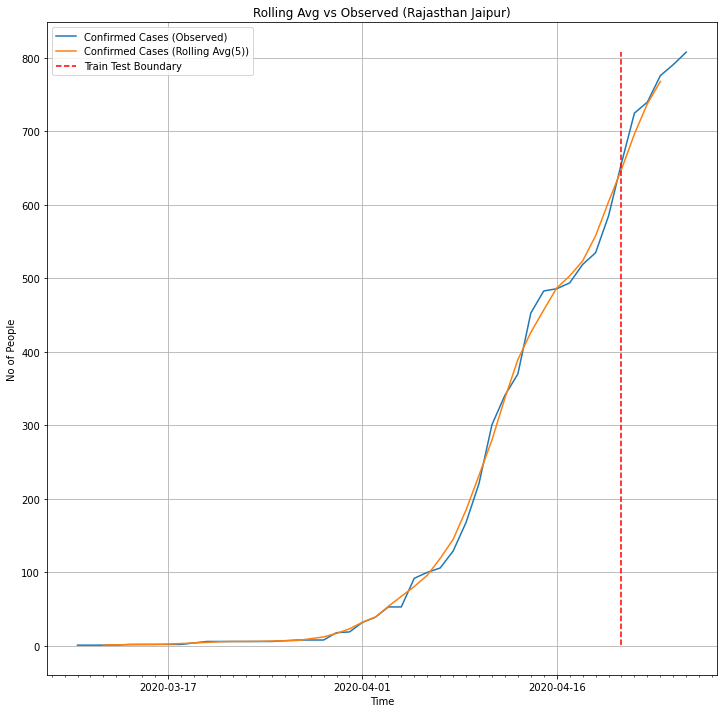

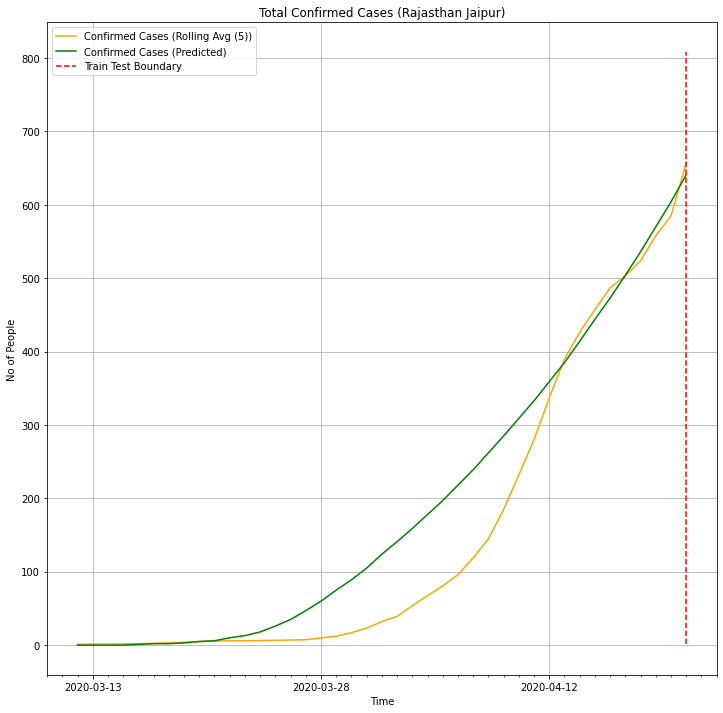

state - Maharashtra, district - Mumbai
train
          date  total_infected
31 2020-04-13          1527.2
32 2020-04-14          1712.6
33 2020-04-15          1870.0
34 2020-04-16          2073.0
35 2020-04-17          2085.0
val
         date  total_infected
0 2020-04-18            2268
1 2020-04-19            2268
2 2020-04-20            2455
3 2020-04-21            2455
4 2020-04-22            2687
100%|██████████| 1500/1500 [01:13<00:00, 20.27trial/s, best loss: 71.92877032175649]
best parameters
 {'P_severe': 0.5131996191451537, 'R0': 4.803245521872695, 'T_inc': 4.28041414690618, 'T_inf': 3.1521659412143728, 'T_recov_severe': 16.187751685293033, 'intervention_amount': 0.3743670058675335}


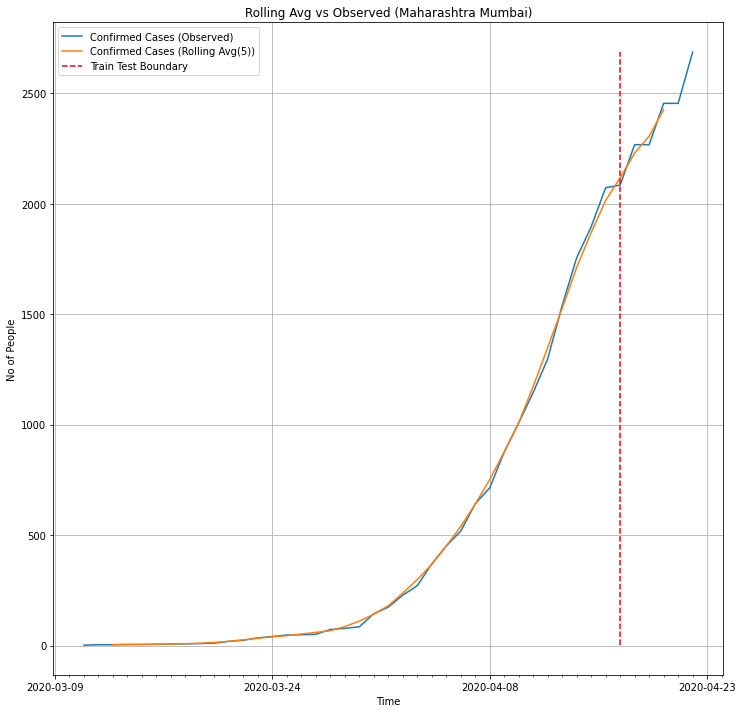

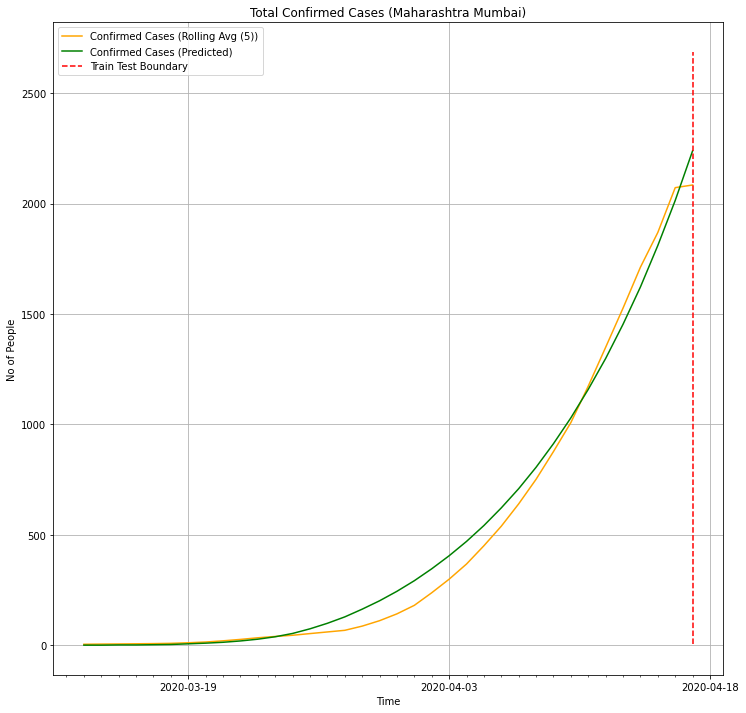

state - Maharashtra, district - Pune
train
          date  total_infected
33 2020-04-13           317.2
34 2020-04-14           360.4
35 2020-04-15           408.6
36 2020-04-16           473.0
37 2020-04-17           504.0
val
         date  total_infected
0 2020-04-18             591
1 2020-04-19             591
2 2020-04-20             591
3 2020-04-21             591
4 2020-04-22             680
100%|██████████| 1500/1500 [01:07<00:00, 22.20trial/s, best loss: 6.720714247756713]
best parameters
 {'P_severe': 0.6601436583955365, 'R0': 2.2786632757083676, 'T_inc': 4.237055090306908, 'T_inf': 3.503251985258888, 'T_recov_severe': 16.32716900787079, 'intervention_amount': 0.8708659284255847}


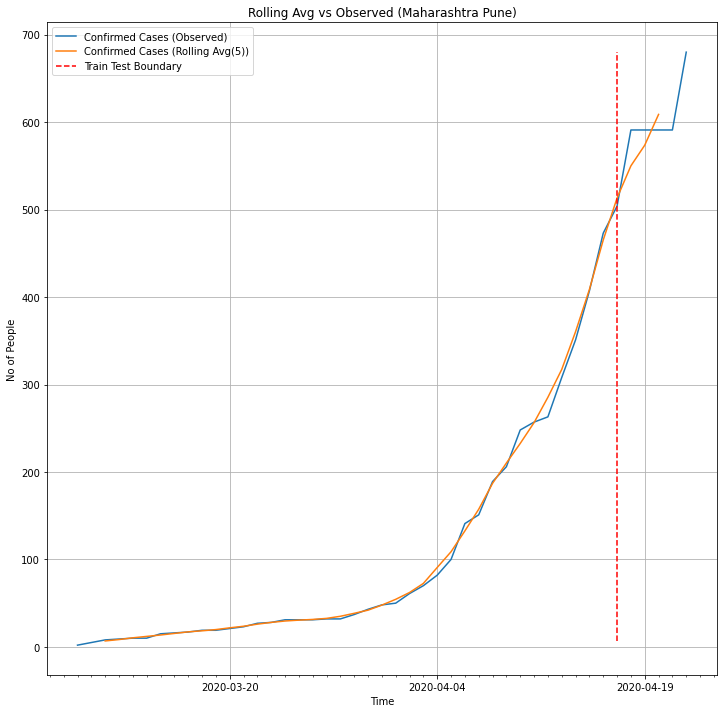

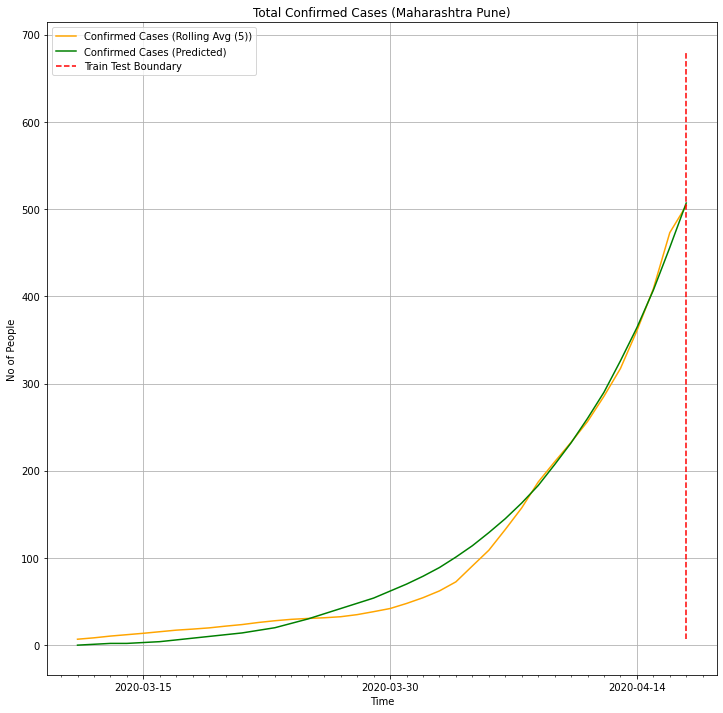

state - Delhi, district - None
train
          date  total_infected
44 2020-04-17          1764.2
45 2020-04-18          1864.8
46 2020-04-19          1968.0
47 2020-04-20          2081.0
48 2020-04-21          2156.0
val
         date  total_infected
0 2020-04-22            2248
1 2020-04-23            2376
2 2020-04-24            2514
3 2020-04-25            2625
4 2020-04-26            2918
100%|██████████| 1500/1500 [01:18<00:00, 19.05trial/s, best loss: 24.345512933598236]
best parameters
 {'P_severe': 0.511122490538475, 'R0': 4.2546515963830895, 'T_inc': 4.632214257923018, 'T_inf': 3.6173947616921596, 'T_recov_severe': 16.40194931360486, 'intervention_amount': 0.2784210228271671}


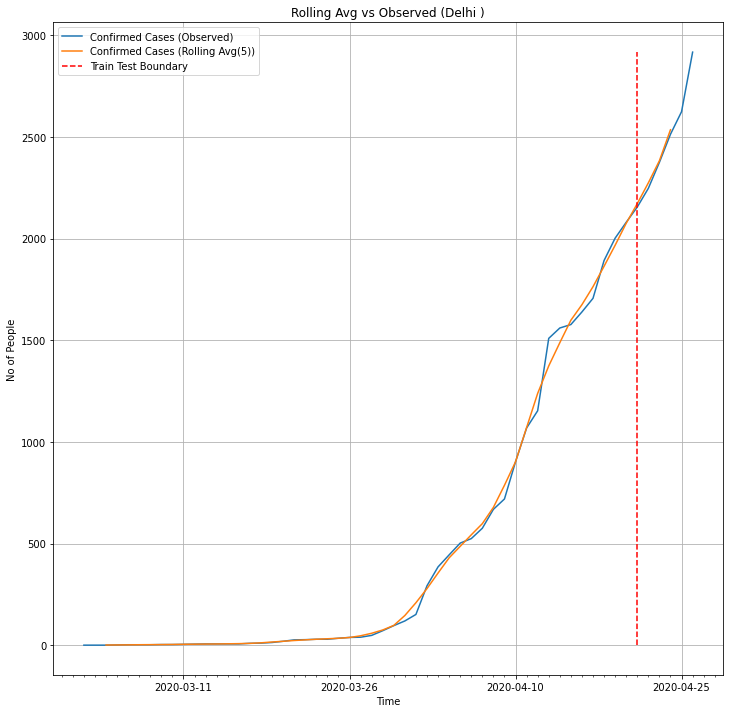

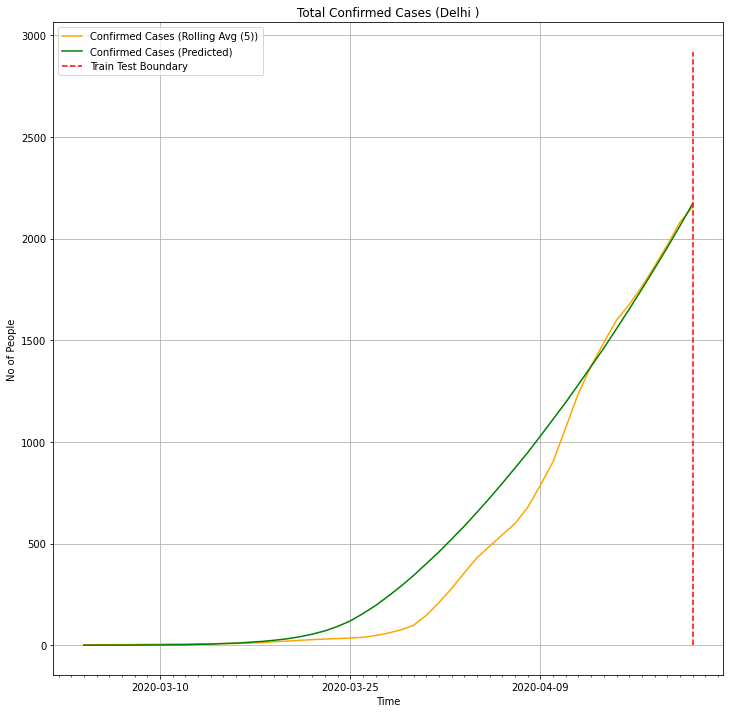

state - Karnataka, district - Bengaluru
train
          date  total_infected
36 2020-04-16            80.2
37 2020-04-17            84.2
38 2020-04-18            87.8
39 2020-04-19            91.0
40 2020-04-20            91.0
val
         date  total_infected
0 2020-04-21              91
1 2020-04-22              93
2 2020-04-23             103
3 2020-04-24             122
4 2020-04-25             135
100%|██████████| 1500/1500 [01:09<00:00, 21.53trial/s, best loss: 1.5874507866387553]
best parameters
 {'P_severe': 0.36546197622139415, 'R0': 2.2302502568770386, 'T_inc': 4.757797862354442, 'T_inf': 3.37090147443427, 'T_recov_severe': 18.33737441039368, 'intervention_amount': 0.4136723053316992}


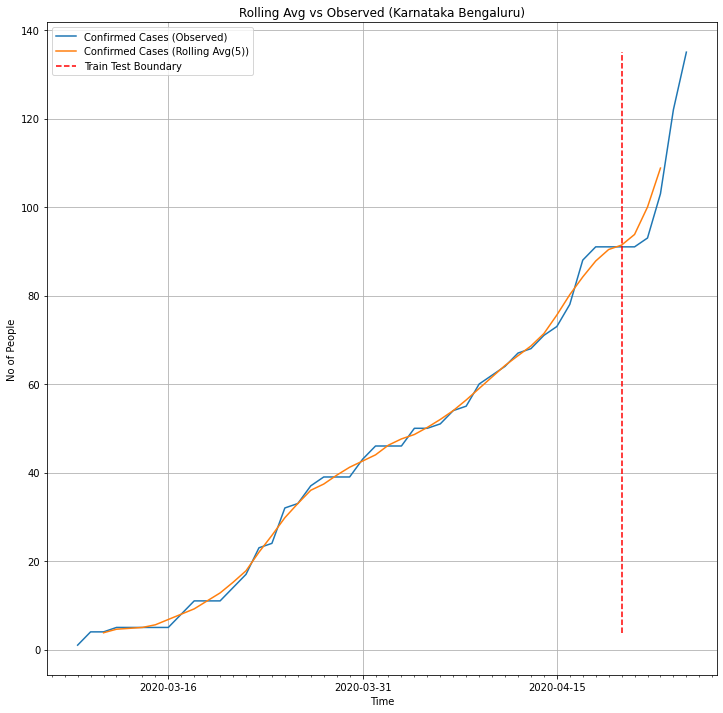

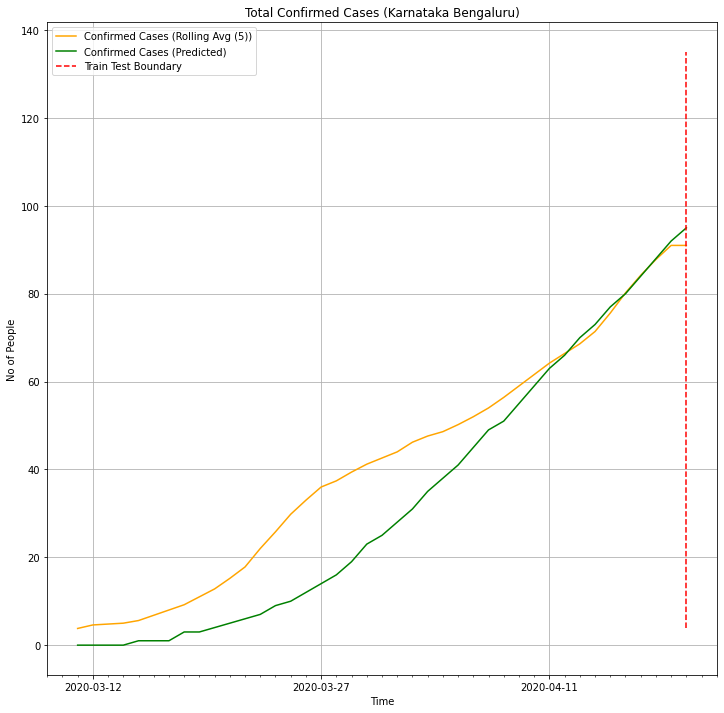

state - Gujarat, district - Ahmadabad
train
          date  total_infected
26 2020-04-17           716.2
27 2020-04-18           875.8
28 2020-04-19          1041.4
29 2020-04-20          1248.0
30 2020-04-21          1373.0
val
         date  total_infected
0 2020-04-22            1501
1 2020-04-23            1652
2 2020-04-24            1821
3 2020-04-25            2003
4 2020-04-26            2181
100%|██████████| 1500/1500 [01:06<00:00, 22.55trial/s, best loss: 32.14560623164541] 
best parameters
 {'P_severe': 0.6405296466699938, 'R0': 3.76740027394218, 'T_inc': 4.051758482618772, 'T_inf': 3.093149624642547, 'T_recov_severe': 14.785888904252113, 'intervention_amount': 0.6970228564993346}


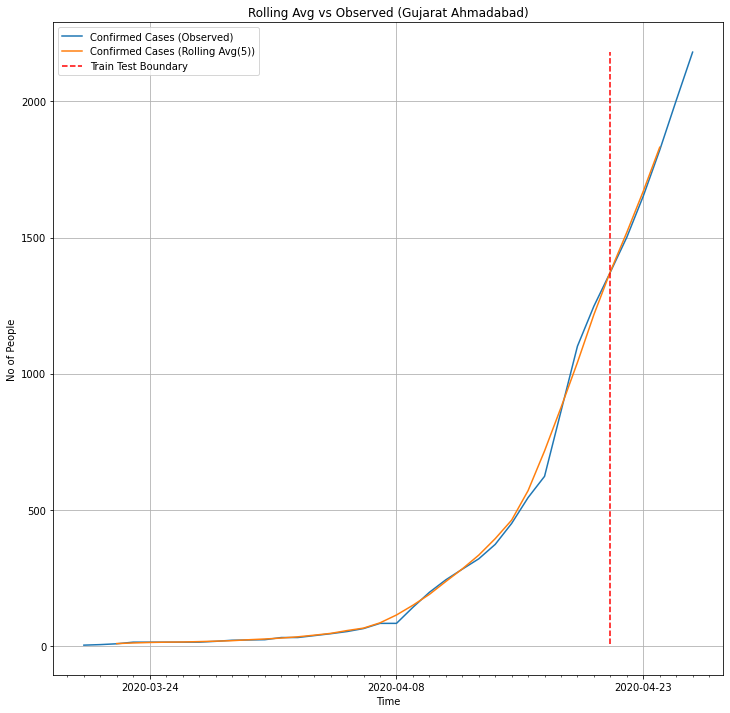

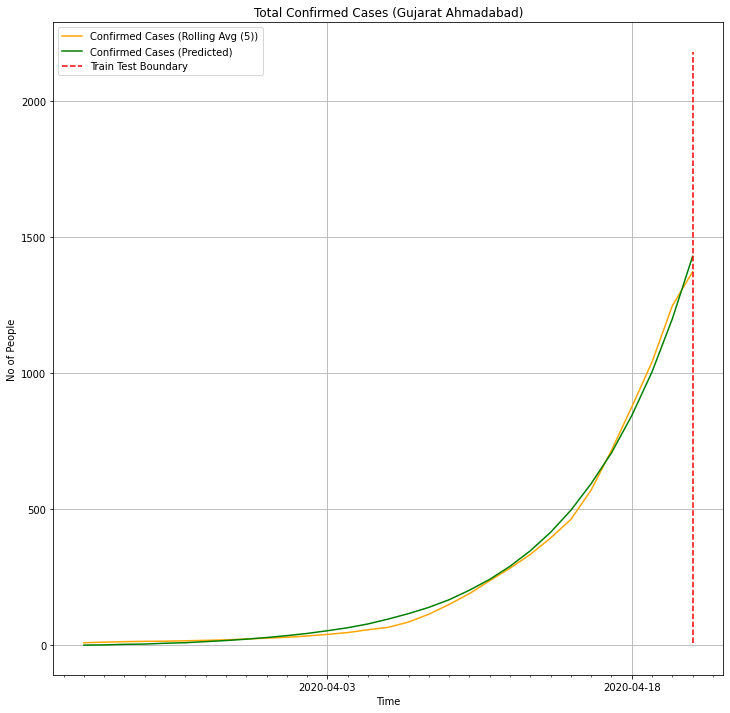

In [9]:
predictions_dict = {}

for state, district in district_to_plot:
    print('state - {}, district - {}'.format(state, district))
    best, default_params, optimiser, df_prediction, df_district = fit_district(dataframes, state, district)
    predictions_dict[(state, district)] = {}
    for name in ['best', 'default_params', 'optimiser', 'df_prediction', 'df_district']:
        predictions_dict[(state, district)][name] = eval(name)
    

In [10]:
df_temp = predictions_dict[('Maharashtra', 'Mumbai')]['df_district']
df_temp.set_index('date', inplace=True)
df_temp.loc['2020-04-18', 'total_infected'] = 2085
df_temp.loc['2020-04-19', 'total_infected'] = 2268
df_temp.loc['2020-04-20', 'total_infected'] = 2724
df_temp.loc['2020-04-21', 'total_infected'] = 3032
df_temp.loc['2020-04-22', 'total_infected'] = 3451
df_temp.reset_index(inplace=True)
predictions_dict[('Maharashtra', 'Mumbai')]['df_district'] = df_temp
predictions_dict[('Maharashtra', 'Mumbai')]['df_district']

,date,total_infected
0,2020-03-11,2
1,2020-03-12,4
2,2020-03-13,4
3,2020-03-14,5
4,2020-03-15,5
5,2020-03-16,6
6,2020-03-17,7
7,2020-03-18,8
8,2020-03-19,9
9,2020-03-20,11


In [11]:
predictions_dict_final = copy.deepcopy(predictions_dict)

In [12]:
def create_classification_report(predictions_dict, predictions_dict_val_train=None):
    
    df_result = pd.DataFrame(columns=['state', 'district', 'train_rmse', 'train_mape', 'pre_intervention_r0', 'post_intervention_r0',
                                      'val_rmse_observed', 'val_mape_observed', 'val_rmse_rolling', 'val_mape_rolling'])
    
    loss_calculator = Loss_Calculator()
    for i, key in enumerate(predictions_dict.keys()):
        df_result.loc[i, 'state'] = key[0]
        df_result.loc[i, 'district'] = key[1]
        df_district = predictions_dict[key]['df_district']
        df_prediction = predictions_dict[key]['df_prediction']
        best = predictions_dict[key]['best']
        optimiser = predictions_dict[key]['optimiser']
        default_params = predictions_dict[key]['default_params']
        
        df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=5)

        loss = loss_calculator._calc_mape(df_prediction.iloc[-10:, :]['total_infected'], df_train.iloc[-10:, :]['total_infected'])
        df_result.loc[i, 'train_mape'] = loss
        loss = loss_calculator._calc_rmse(df_prediction.iloc[-10:, :]['total_infected'], df_train.iloc[-10:, :]['total_infected'])
        df_result.loc[i, 'train_rmse'] = loss

        df_result.loc[i, 'pre_intervention_r0'] = best['R0']
        df_result.loc[i, 'post_intervention_r0'] = best['R0']*best['intervention_amount']

        normalising_ratio = (df_train['total_infected'].iloc[-1] / df_prediction['total_infected'].iloc[-1])
        df_prediction = optimiser.solve(best, default_params, df_train, end_date=df_val.iloc[-1, :]['date'])
        df_prediction.loc[df_prediction['date'] == df_prediction.iloc[-1]['date'], 'total_infected'] = df_prediction.loc[ df_prediction['date'] == df_prediction.iloc[-1]['date'], 'total_infected'] * normalising_ratio
        df_prediction.loc[df_prediction['date'].isin(df_val['date']), 'total_infected'] = df_prediction.loc[ df_prediction['date'].isin(df_val['date']), 'total_infected'] * normalising_ratio
        df_prediction = df_prediction[df_prediction['date'].isin(df_val['date'])]
        df_prediction.reset_index(inplace=True, drop=True)

        loss = loss_calculator._calc_mape(df_prediction['total_infected'], df_val['total_infected'])
        df_result.loc[i, 'val_mape_observed'] = loss
        loss = loss_calculator._calc_rmse(df_prediction['total_infected'], df_val['total_infected'])
        df_result.loc[i, 'val_rmse_observed'] = loss

        _, df_val, _ = train_val_split(df_district, val_rollingmean=True, val_size=5)

        loss = loss_calculator._calc_mape(df_prediction['total_infected'], df_val['total_infected'])
        df_result.loc[i, 'val_mape_rolling'] = loss
        loss = loss_calculator._calc_rmse(df_prediction['total_infected'], df_val['total_infected'])
        df_result.loc[i, 'val_rmse_rolling'] = loss
        
        df_result.loc[i, 'train_period'] = '{} to {}'.format(df_train['date'].iloc[-10].date(), df_train['date'].iloc[-1].date())
        df_result.loc[i, 'val_period'] = '{} to {}'.format(df_val['date'].iloc[0].date(), df_val['date'].iloc[-1].date())
        df_result.loc[i, 'init_date'] = '{}'.format(df_train['date'].iloc[0].date())
        
        if predictions_dict_val_train != None:
            df_district = predictions_dict_val_train[key]['df_district']
            df_prediction = predictions_dict_val_train[key]['df_prediction']
            
            df_result.loc[i, 'second_train_period'] = '{} to {}'.format(df_district['date'].iloc[-10].date(), df_district['date'].iloc[-1].date())
            
            df_district.set_index('date', inplace=True)
            df_prediction.set_index('date', inplace=True)
            loss = loss_calculator._calc_mape(df_prediction.iloc[-10:, :]['total_infected'], df_district.iloc[-10:, :]['total_infected'])
            df_result.loc[i, 'second_train_mape'] = loss
            df_district.reset_index(inplace=True)
            df_prediction.reset_index(inplace=True)

    return df_result

In [13]:
def create_full_plots(predictions_dict):
    for i, key in enumerate(predictions_dict.keys()):
        
        df_district = predictions_dict[key]['df_district']
        df_prediction = predictions_dict[key]['df_prediction']
        best = predictions_dict[key]['best']
        optimiser = predictions_dict[key]['optimiser']
        default_params = predictions_dict[key]['default_params']
        
        df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=5)
        
        # Create state init values before solving on val set
        last_prediction = df_prediction.iloc[-1, 1:12]
        normalising_ratio = (df_train['total_infected'].iloc[-1] / df_prediction['total_infected'].iloc[-1])
        last_prediction[1:] = list(map(lambda x : int(round(x)), df_prediction.iloc[-1, 2:12] * normalising_ratio))
        last_prediction[0] = default_params['N'] - sum(last_prediction[1:])
        state_init_values = last_prediction.to_dict(OrderedDict)
        
#         df_prediction = optimiser.solve(best, default_params, df_train, start_date=df_val.iloc[0, :]['date'], end_date=df_val.iloc[-1, :]['date'], 
#                                         state_init_values=state_init_values)
        df_prediction = optimiser.solve(best, default_params, df_train, end_date=df_val.iloc[-1, :]['date'])
        df_prediction.loc[df_prediction['date'] == df_prediction.iloc[-1]['date'], 'total_infected'] = df_prediction.loc[ df_prediction['date'] == df_prediction.iloc[-1]['date'], 'total_infected'] * normalising_ratio
        df_prediction.loc[df_prediction['date'].isin(df_val['date']), 'total_infected'] = df_prediction.loc[ df_prediction['date'].isin(df_val['date']), 'total_infected'] * normalising_ratio
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.plot(df_district['date'], df_district['total_infected'], label='Confirmed Cases (Observed)')
        ax.plot(df_true_fitting['date'], df_true_fitting['total_infected'], color='orange', label='Confirmed Cases (Rolling Avg (5))')
        ax.plot(df_prediction['date'], df_prediction['total_infected'], '-g', label='Confirmed Cases (Predicted)')
        ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train['total_infected']), max(df_val['total_infected'])], '--r', label='Train Test Boundary')
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.ylabel('No of People')
        plt.xlabel('Time')
        plt.legend()
        plt.title('Total Confirmed Cases Extrapolated ({})'.format(key))
        plt.grid()
        plt.show()

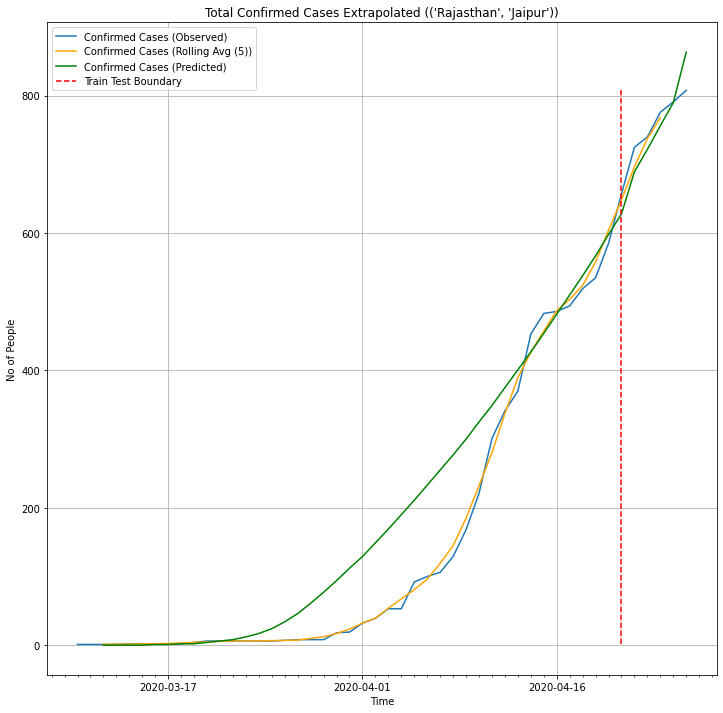

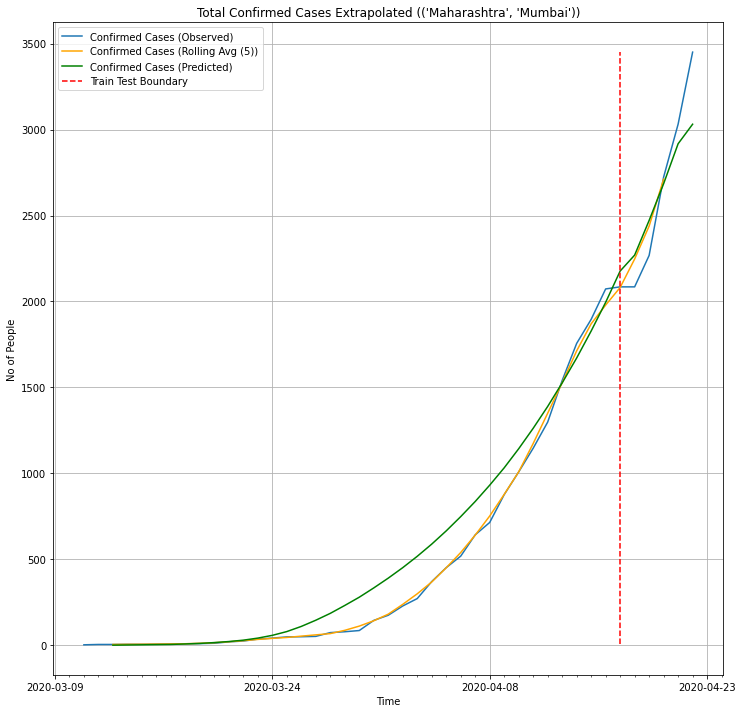

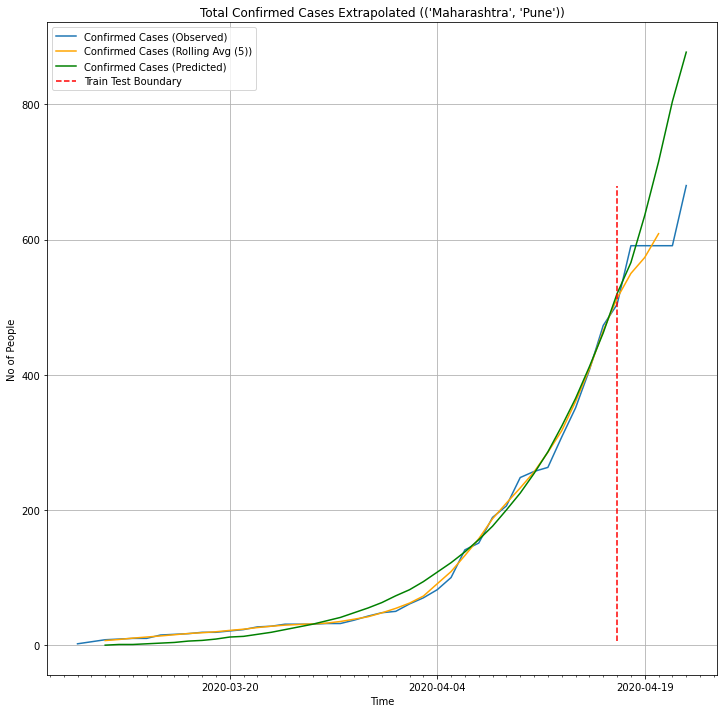

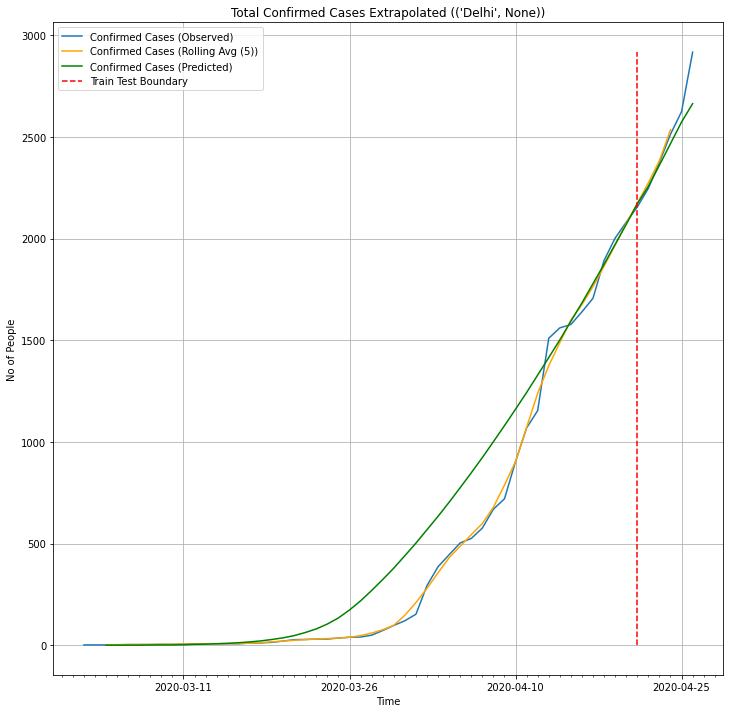

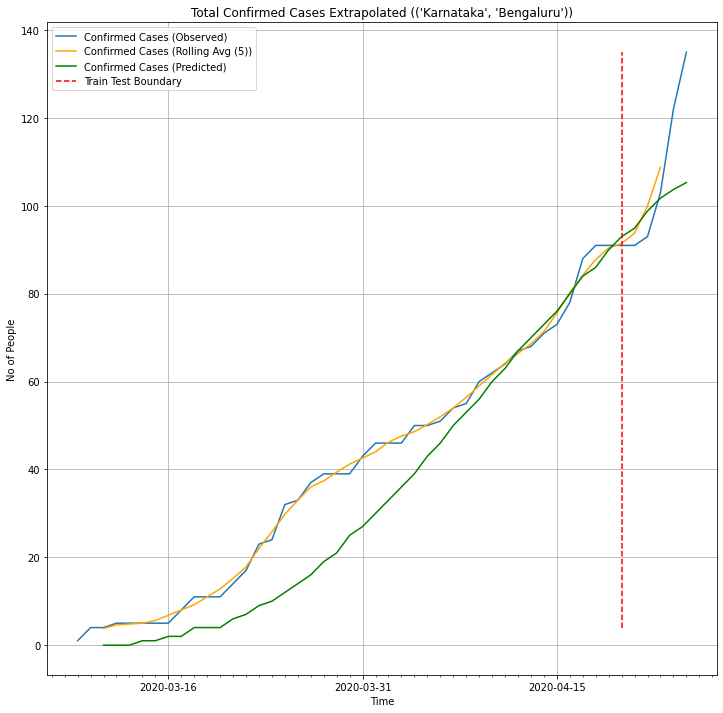

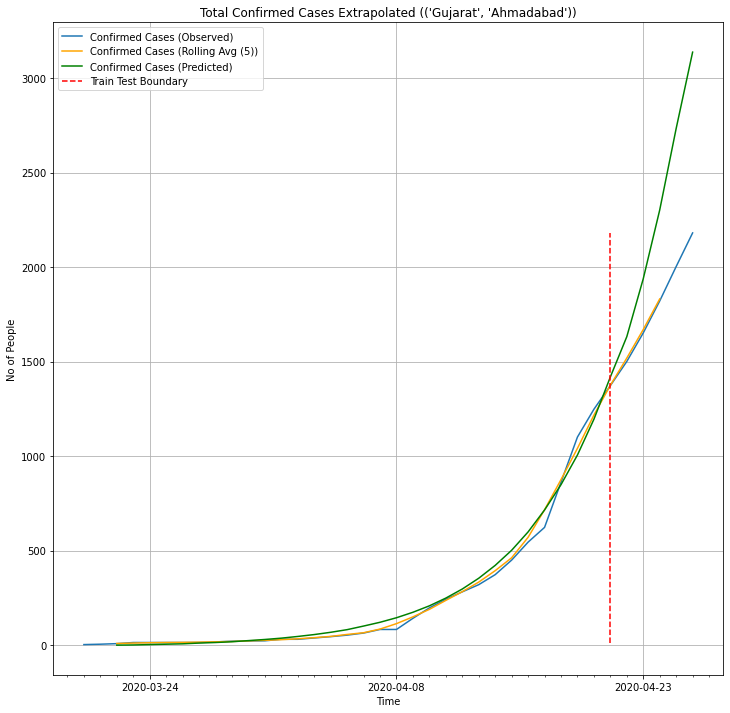

In [75]:
create_full_plots(predictions_dict)

In [14]:
df_result = create_classification_report(predictions_dict, None)
df_result

,state,district,train_rmse,train_mape,pre_intervention_r0,post_intervention_r0,val_rmse_observed,val_mape_observed,val_rmse_rolling,val_mape_rolling,train_period,val_period,init_date
0,Rajasthan,Jaipur,13.9126,2.66432,4.66921,1.31471,39.7265,3.64127,37.761,3.0081,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-12
1,Maharashtra,Mumbai,71.9288,4.18663,4.80325,1.79818,206.625,7.66883,138.617,4.57661,2020-04-08 to 2020-04-17,2020-04-18 to 2020-04-22,2020-03-13
2,Maharashtra,Pune,6.72071,1.52892,2.27866,1.98441,130.185,17.8056,128.171,17.2588,2020-04-08 to 2020-04-17,2020-04-18 to 2020-04-22,2020-03-11
3,Delhi,None,24.3455,1.30199,4.25465,1.18458,92.3287,1.83055,93.6431,1.96439,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-04
4,Karnataka,Bengaluru,1.58745,1.48143,2.23025,0.922593,16.264,9.45042,16.4199,9.33264,2020-04-11 to 2020-04-20,2020-04-21 to 2020-04-25,2020-03-11
5,Gujarat,Ahmadabad,32.1456,3.96425,3.7674,2.62596,619.096,27.6316,614.951,26.9708,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-22


state - Rajasthan, district - Jaipur
train
          date  total_infected
41 2020-04-22           696.6
42 2020-04-23           737.8
43 2020-04-24           768.0
44 2020-04-25           791.0
45 2020-04-26           808.0
val
 None
100%|██████████| 1500/1500 [01:13<00:00, 20.37trial/s, best loss: 15.504192981255102]
best parameters
 {'P_severe': 0.7831271248108468, 'R0': 4.920396561135409, 'T_inc': 4.8327616789032435, 'T_inf': 3.0548713777460117, 'T_recov_severe': 13.614264715783126, 'intervention_amount': 0.26482715247353494}


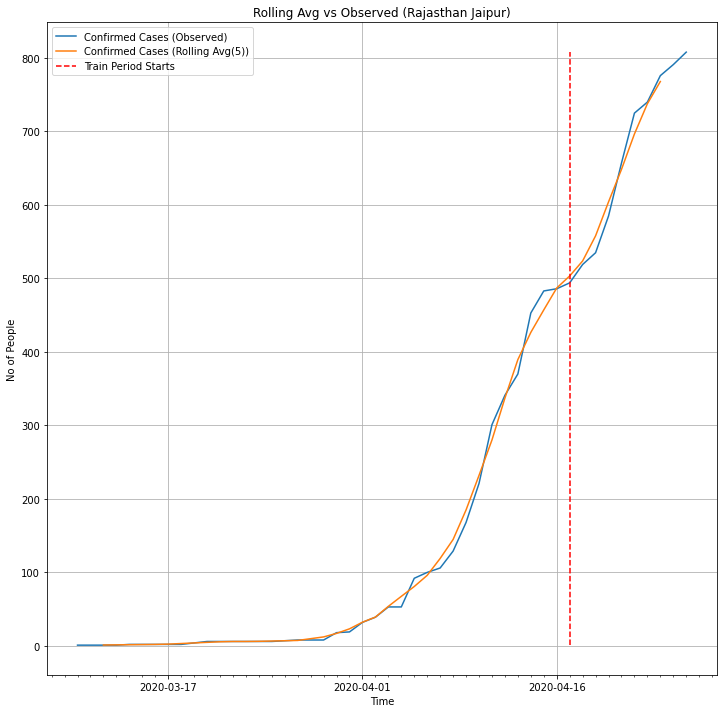

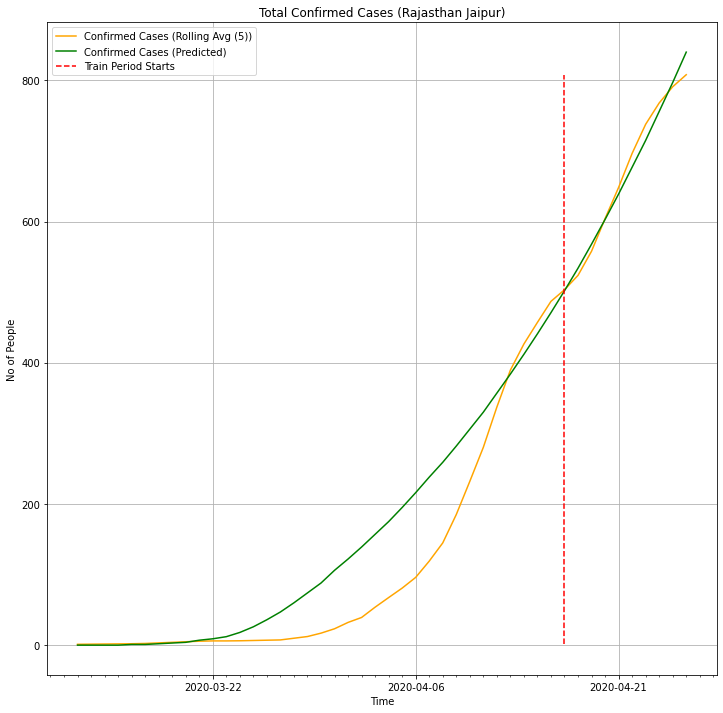

state - Maharashtra, district - Mumbai
train
          date  total_infected
36 2020-04-18          2229.8
37 2020-04-19          2306.2
38 2020-04-20          2426.6
39 2020-04-21          2455.0
40 2020-04-22          2687.0
val
 None
100%|██████████| 1500/1500 [01:16<00:00, 19.69trial/s, best loss: 73.47053831298638]
best parameters
 {'P_severe': 0.8975622865577823, 'R0': 4.998920741651091, 'T_inc': 4.068833587543367, 'T_inf': 3.1729365020972087, 'T_recov_severe': 11.213122579836488, 'intervention_amount': 0.2561396185872412}


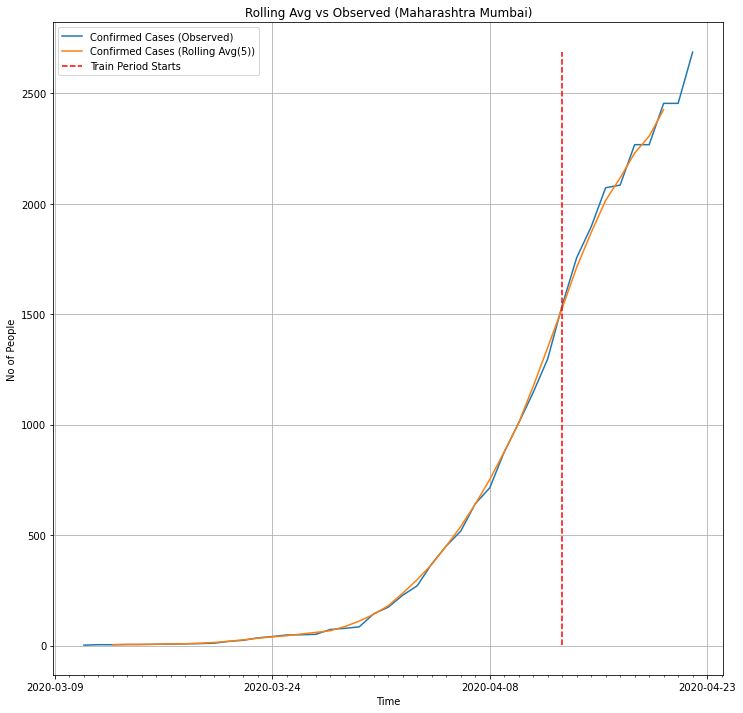

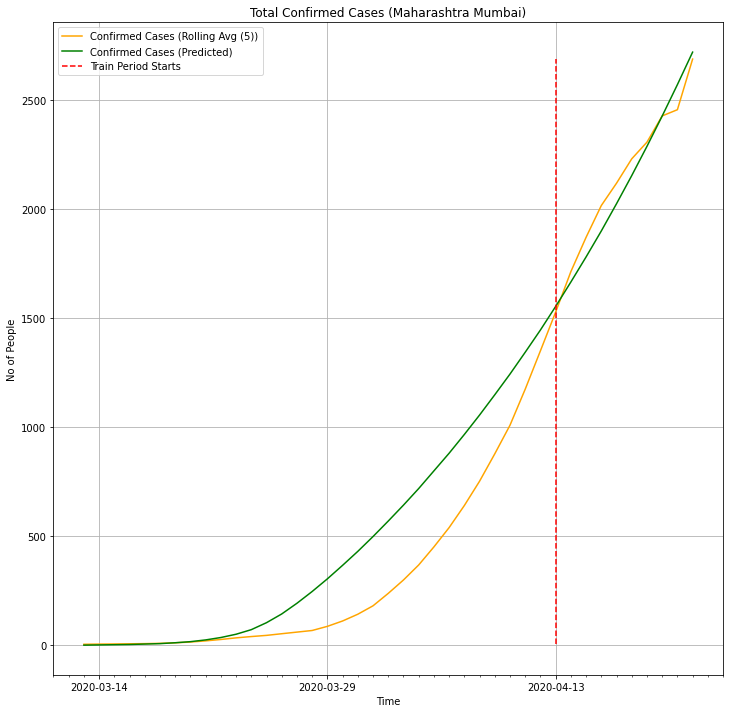

state - Maharashtra, district - Pune
train
          date  total_infected
38 2020-04-18           550.0
39 2020-04-19           573.6
40 2020-04-20           608.8
41 2020-04-21           591.0
42 2020-04-22           680.0
val
 None
100%|██████████| 1500/1500 [01:07<00:00, 22.08trial/s, best loss: 27.225796590733584]
best parameters
 {'P_severe': 0.9214149536750188, 'R0': 2.812399005249281, 'T_inc': 4.293370374408462, 'T_inf': 3.860940298939351, 'T_recov_severe': 17.099969565644837, 'intervention_amount': 0.5445481995996502}


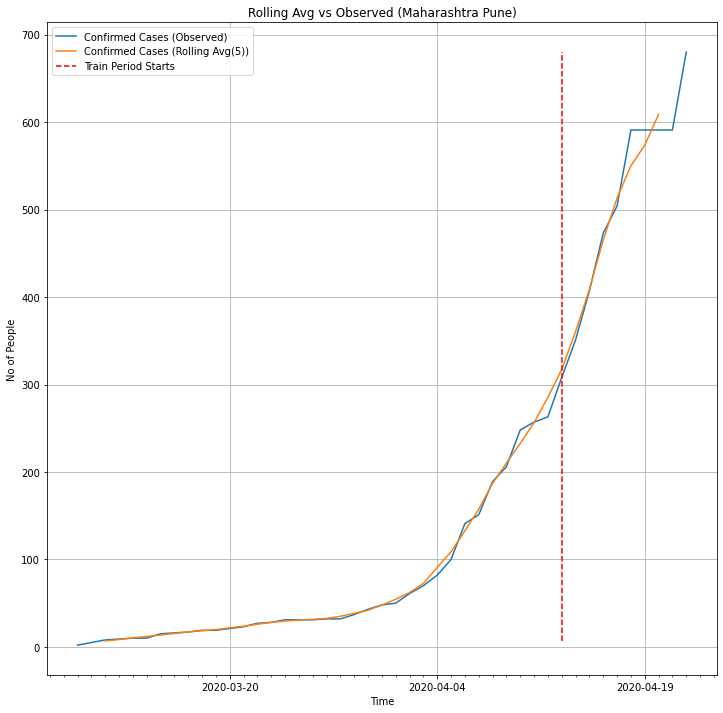

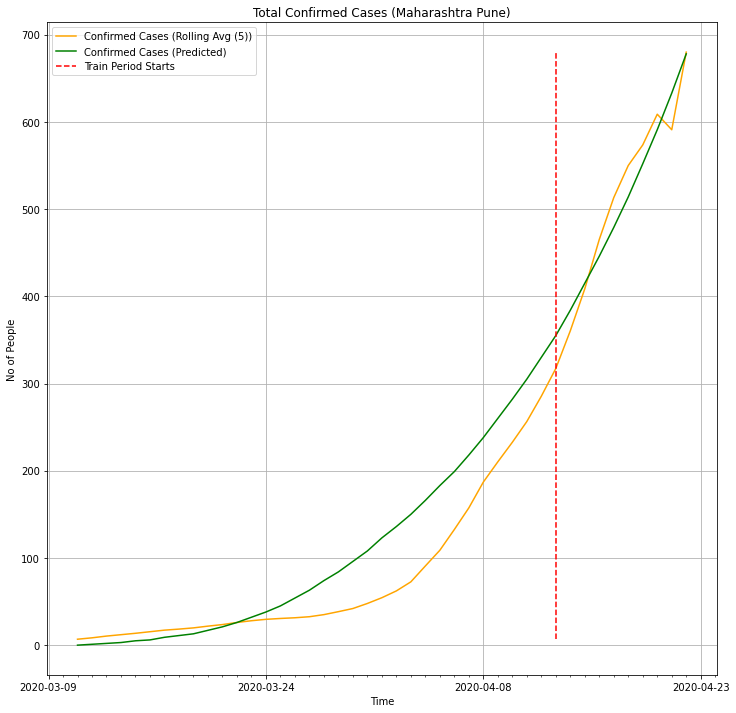

state - Delhi, district - None
train
          date  total_infected
49 2020-04-22          2275.0
50 2020-04-23          2383.8
51 2020-04-24          2536.2
52 2020-04-25          2625.0
53 2020-04-26          2918.0
val
 None
100%|██████████| 1500/1500 [01:18<00:00, 19.00trial/s, best loss: 42.97701711380163]
best parameters
 {'P_severe': 0.4867533752034608, 'R0': 4.0251287204282375, 'T_inc': 4.4584169799138875, 'T_inf': 3.5231573184787037, 'T_recov_severe': 15.25679146372962, 'intervention_amount': 0.30910545162932557}


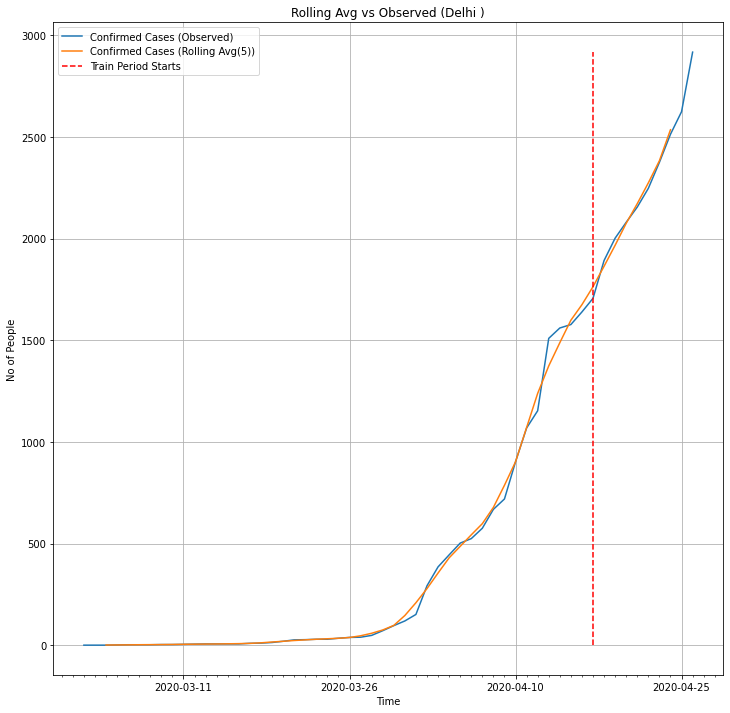

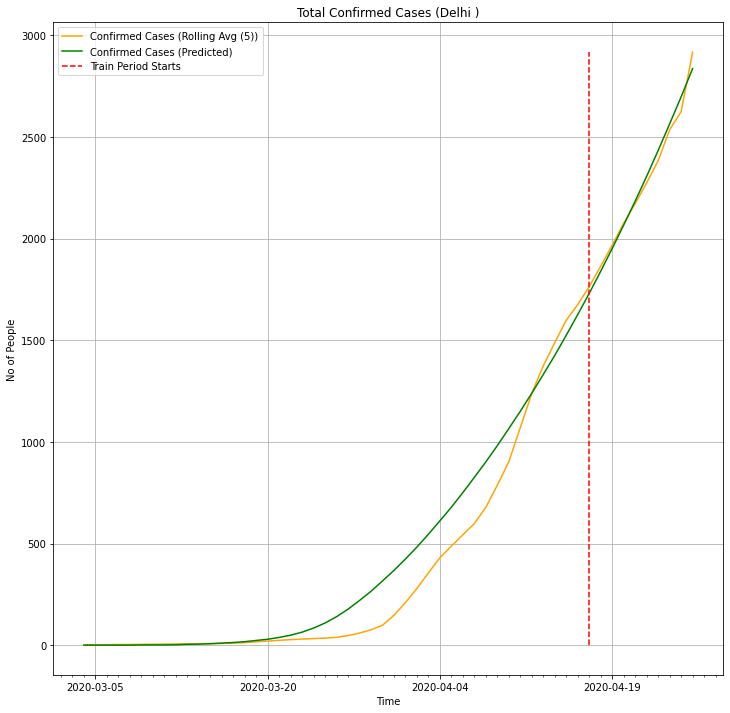

state - Karnataka, district - Bengaluru
train
          date  total_infected
41 2020-04-21            93.8
42 2020-04-22           100.0
43 2020-04-23           108.8
44 2020-04-24           122.0
45 2020-04-25           135.0
val
 None
100%|██████████| 1500/1500 [01:08<00:00, 22.04trial/s, best loss: 5.0330905018686085]
best parameters
 {'P_severe': 0.9699131932021057, 'R0': 1.6062080642445526, 'T_inc': 4.045959365426783, 'T_inf': 3.2149481076687803, 'T_recov_severe': 14.692249491922613, 'intervention_amount': 0.8582734071286162}


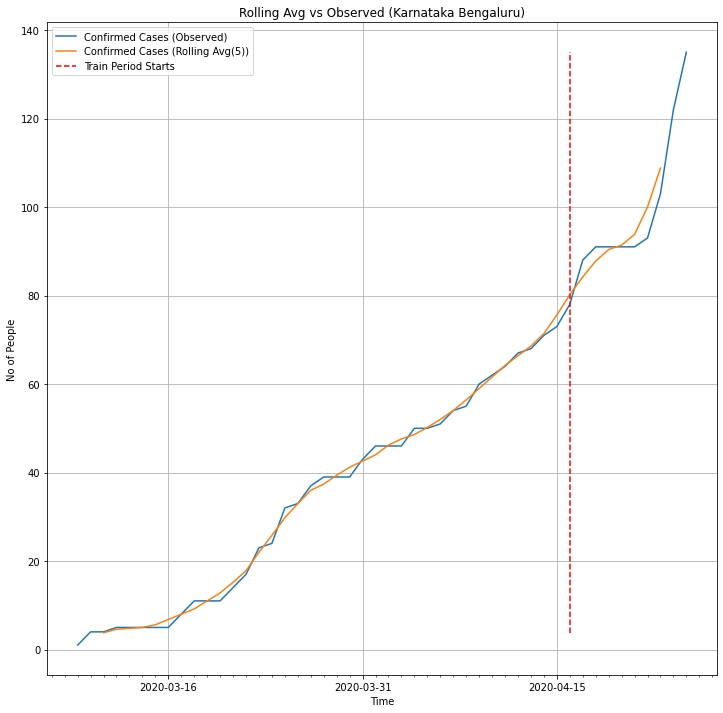

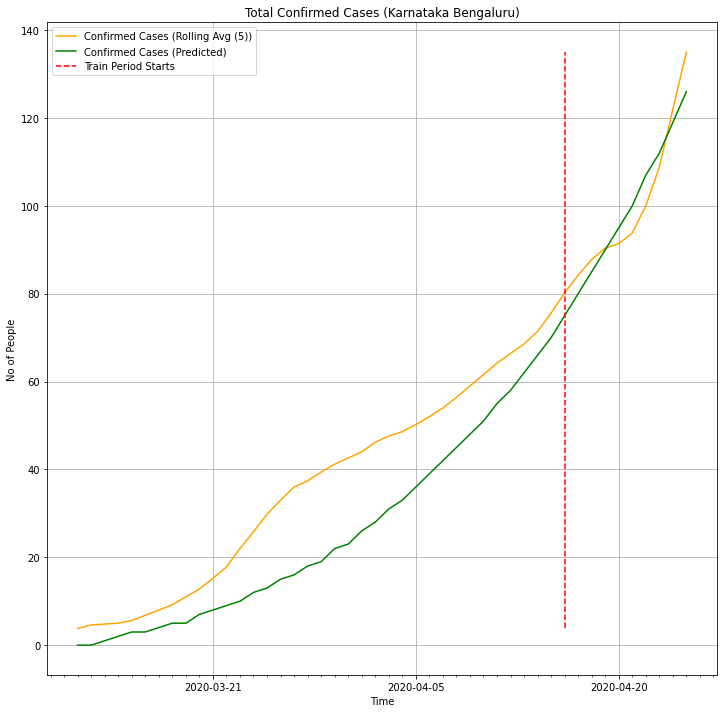

state - Gujarat, district - Ahmadabad
train
          date  total_infected
31 2020-04-22          1519.0
32 2020-04-23          1670.0
33 2020-04-24          1831.6
34 2020-04-25          2003.0
35 2020-04-26          2181.0
val
 None
100%|██████████| 1500/1500 [01:07<00:00, 22.15trial/s, best loss: 128.38979710241776]
best parameters
 {'P_severe': 0.9774444694807592, 'R0': 4.849694365703909, 'T_inc': 4.355776143160691, 'T_inf': 3.2717475519373904, 'T_recov_severe': 13.527916084538704, 'intervention_amount': 0.47394350875472585}


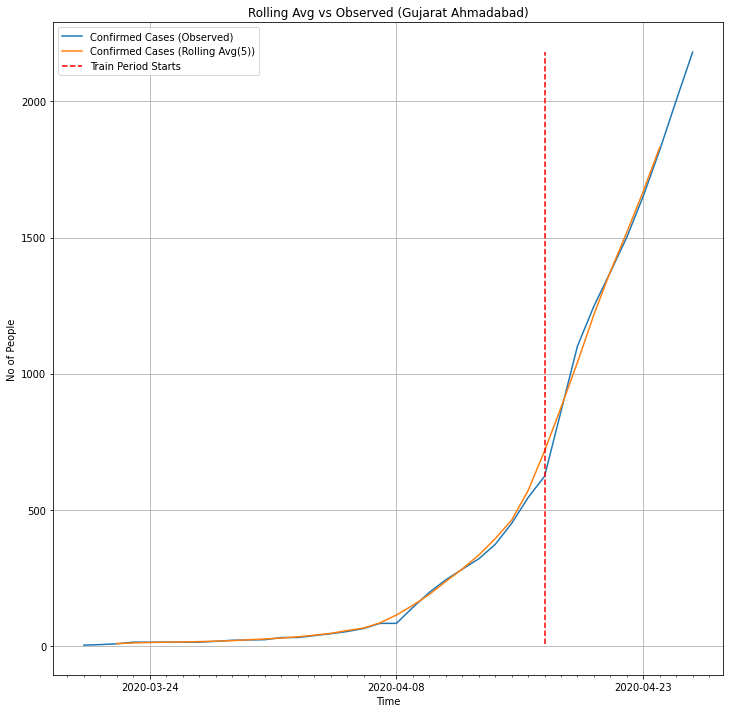

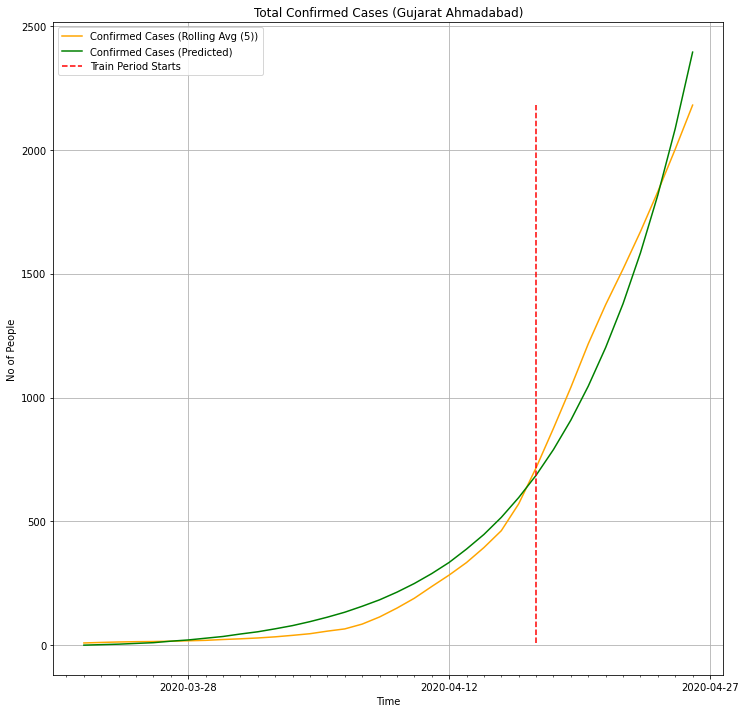

In [31]:
predictions_dict_val_train = {}

for state, district in district_to_plot:
    print('state - {}, district - {}'.format(state, district))
    best, default_params, optimiser, df_prediction, df_district = fit_district(dataframes, state, district, train_on_val=True)
    predictions_dict_val_train[(state, district)] = {}
    for name in ['best', 'default_params', 'optimiser', 'df_prediction', 'df_district']:
        predictions_dict_val_train[(state, district)][name] = eval(name)
    

In [32]:
df_result = create_classification_report(predictions_dict, predictions_dict_val_train)
df_result

,state,district,train_rmse,train_mape,pre_intervention_r0,post_intervention_r0,val_rmse_observed,val_mape_observed,val_rmse_rolling,val_mape_rolling,train_period,val_period,init_date,second_train_period,second_train_mape
0,Rajasthan,Jaipur,13.9126,2.66432,4.66921,1.31471,39.7265,3.64127,37.761,3.0081,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-12,2020-04-17 to 2020-04-26,3.378980
1,Maharashtra,Mumbai,71.9288,4.18663,4.80325,1.79818,206.625,7.66883,138.617,4.57661,2020-04-08 to 2020-04-17,2020-04-18 to 2020-04-22,2020-03-13,2020-04-13 to 2020-04-22,3.642861
2,Maharashtra,Pune,6.72071,1.52892,2.27866,1.98441,130.185,17.8056,128.171,17.2588,2020-04-08 to 2020-04-17,2020-04-18 to 2020-04-22,2020-03-11,2020-04-13 to 2020-04-22,6.432408
3,Delhi,None,24.3455,1.30199,4.25465,1.18458,92.3287,1.83055,93.6431,1.96439,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-04,2020-04-17 to 2020-04-26,2.142088
4,Karnataka,Bengaluru,1.58745,1.48143,2.23025,0.922593,16.264,9.45042,16.4199,9.33264,2020-04-11 to 2020-04-20,2020-04-21 to 2020-04-25,2020-03-11,2020-04-16 to 2020-04-25,6.783240
5,Gujarat,Ahmadabad,32.1456,3.96425,3.7674,2.62596,619.096,27.6316,614.951,26.9708,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-22,2020-04-17 to 2020-04-26,9.090878


In [113]:
df_result.to_csv('../../result.csv')

In [69]:
df_result

,state,district,train_rmse,train_mape,pre_intervention_r0,post_intervention_r0,val_rmse_observed,val_mape_observed,val_rmse_rolling,val_mape_rolling,train_period,val_period,init_date,second_train_period,second_train_mape
0,Rajasthan,Jaipur,13.9126,2.66432,4.66921,1.31471,39.7265,3.64127,37.761,3.0081,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-12,2020-04-17 to 2020-04-26,3.378980
1,Maharashtra,Mumbai,71.9288,4.18663,4.80325,1.79818,206.625,7.66883,138.617,4.57661,2020-04-08 to 2020-04-17,2020-04-18 to 2020-04-22,2020-03-13,2020-04-13 to 2020-04-22,3.642861
2,Maharashtra,Pune,6.72071,1.52892,2.27866,1.98441,130.185,17.8056,128.171,17.2588,2020-04-08 to 2020-04-17,2020-04-18 to 2020-04-22,2020-03-11,2020-04-13 to 2020-04-22,6.432408
3,Delhi,None,24.3455,1.30199,4.25465,1.18458,92.3287,1.83055,93.6431,1.96439,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-04,2020-04-17 to 2020-04-26,2.142088
4,Karnataka,Bengaluru,1.58745,1.48143,2.23025,0.922593,16.264,9.45042,16.4199,9.33264,2020-04-11 to 2020-04-20,2020-04-21 to 2020-04-25,2020-03-11,2020-04-16 to 2020-04-25,6.783240
5,Gujarat,Ahmadabad,32.1456,3.96425,3.7674,2.62596,619.096,27.6316,614.951,26.9708,2020-04-12 to 2020-04-21,2020-04-22 to 2020-04-26,2020-03-22,2020-04-17 to 2020-04-26,9.090878


In [75]:
params = {}
regional_model_params_array = []

for key in predictions_dict_val_train.keys():
    district_dict = {}
    state, district = key[0], key[1]
    try:
        district_dict['region_name'] = district.lower()
        district_dict['region_type'] = 'district'
    except Exception as e:
        district_dict['region_name'] = state.lower()
        district_dict['region_type'] = 'state'
    district_dict['model_name'] = 'SEIR'
    
    district_dict['model_parameters'] = {**copy.deepcopy(predictions_dict_val_train[key]['best']), **copy.deepcopy(predictions_dict_val_train[key]['default_params'])}
    district_dict['model_parameters']['starting_date'] = district_dict['model_parameters']['starting_date'].strftime("%Y-%m-%d") 
    
    if state == 'Delhi':
        error = df_result.loc[np.logical_and(df_result['state'] == state, 1), 'val_mape_observed'].tolist()[0]
    else:
        error = df_result.loc[np.logical_and(df_result['state'] == state, df_result['district'] == district), 'val_mape_observed'].tolist()[0]
    district_dict['val_error'] = error
    
    regional_model_params_array.append(district_dict)
    
    
params['regional_model_params'] = regional_model_params_array

In [76]:
params

{'regional_model_params': [{'region_name': 'jaipur',
   'region_type': 'district',
   'model_name': 'SEIR',
   'model_parameters': {'P_severe': 0.7831271248108468,
    'R0': 4.920396561135409,
    'T_inc': 4.8327616789032435,
    'T_inf': 3.0548713777460117,
    'T_recov_severe': 13.614264715783126,
    'intervention_amount': 0.26482715247353494,
    'N': 10000000.0,
    'init_infected': 1.2,
    'intervention_day': 13,
    'intervention_removal_day': 95,
    'T_hosp': 0.001,
    'P_fatal': 0.01,
    'starting_date': '2020-03-12'},
   'val_error': 3.641265977125208},
  {'region_name': 'mumbai',
   'region_type': 'district',
   'model_name': 'SEIR',
   'model_parameters': {'P_severe': 0.8975622865577823,
    'R0': 4.998920741651091,
    'T_inc': 4.068833587543367,
    'T_inf': 3.1729365020972087,
    'T_recov_severe': 11.213122579836488,
    'intervention_amount': 0.2561396185872412,
    'N': 10000000.0,
    'init_infected': 4.0,
    'intervention_day': 12,
    'intervention_removal_day

In [77]:
with open('../../model_params_seir_t.json', 'w') as fp:
    json.dump(params, fp)

In [41]:
def get_forecasts(fitting):
    new_lockdown_removal_date = "2020-06-15"
    new_lockdown_removal_date = datetime.datetime.strptime(new_lockdown_removal_date, '%Y-%m-%d')
    end_date = "2020-06-30"
    forecasts = defaultdict(dict)
    for region in fitting:
        city = fitting[region].copy()
        city['default_params']['intervention_removal_day'] = (new_lockdown_removal_date - city['default_params']['starting_date']).days
        df_train, df_val, df_true_fitting = train_val_split(city['df_district'], val_rollingmean=False, val_size=5)
        optimiser = city['optimiser']
        forecasts[region] = optimiser.solve(city['best'], city['default_params'], df_val, end_date=end_date)
    return forecasts

forecasts = get_forecasts(predictions_dict_val_train)

In [42]:
end_date = "2020-06-29"
simulate_till = datetime.datetime.strptime('2020-06-30', '%Y-%m-%d')
dfs = defaultdict()
for region in forecasts:
    state, district = region
    
    columns = ['forecastRunDate', 'regionType', 'region', 'model_name', 'error_function', 'error_value', 'current_total', 'current_active', 'current_recovered', 
           'current_deceased', 'current_hosptialized', 'current_icu', 'current_ventilator', 'predictionDate', 'active_mean', 'active_min', 
           'active_max', 'hospitalized_mean', 'hospitalized_min', 'hospitalized_max', 'icu_mean', 'icu_min', 'icu_max', 'deceased_mean', 
           'deceased_min', 'deceased_max', 'recovered_mean', 'recovered_min', 'recovered_max', 'total_mean', 'total_min', 'total_max']

    df_output = pd.DataFrame(columns = columns)
    
    city = predictions_dict_val_train[region].copy()
    df_train, df_val, df_true_fitting = train_val_split(city['df_district'], val_rollingmean=False, val_size=5)
    start_date = df_train.iloc[0, 0]
    
    prediction_daterange = pd.date_range(start=start_date, end=simulate_till)
    no_of_predictions = len(prediction_daterange)
    
    df_output['predictionDate'] = prediction_daterange
    df_output['forecastRunDate'] = [datetime.datetime.today().date()]*no_of_predictions
    
    df_output['regionType'] = ['city']*no_of_predictions
    
    df_output['model_name'] = ['SEIR']*no_of_predictions
    df_output['error_function'] = ['MAPE']*no_of_predictions
    
    if state == 'Delhi':
        error = df_result.loc[np.logical_and(df_result['state'] == state, 1), 'val_mape_observed'].tolist()
    else:
        error = df_result.loc[np.logical_and(df_result['state'] == state, df_result['district'] == district), 'val_mape_observed'].tolist()
        
    df_output['error_value'] = [error[0]]*no_of_predictions

    pred_hospitalisations = forecasts[region]['hospitalisations']
    df_output['active_mean'] = pred_hospitalisations
    df_output['active_min'] = (1 - 0.01*error[0])*pred_hospitalisations
    df_output['active_max'] = (1 + 0.01*error[0])*pred_hospitalisations
    
    df_output['hospitalized_mean'] = pred_hospitalisations
    df_output['hospitalized_min'] = (1 - 0.01*error[0])*pred_hospitalisations
    df_output['hospitalized_max'] = (1 - 0.01*error[0])*pred_hospitalisations
    
    df_output['icu_mean'] = 0.02*pred_hospitalisations
    df_output['icu_min'] = (1 - 0.01*error[0])*0.02*pred_hospitalisations
    df_output['icu_max'] = (1 - 0.01*error[0])*0.02*pred_hospitalisations
    
    pred_recoveries = forecasts[region]['recoveries']
    df_output['recovered_mean'] = pred_recoveries
    df_output['recovered_min'] = (1 - 0.01*error[0])*pred_recoveries
    df_output['recovered_max'] = (1 - 0.01*error[0])*pred_recoveries
    
    pred_fatalities = forecasts[region]['fatalities']
    df_output['deceased_mean'] = pred_fatalities
    df_output['deceased_min'] = (1 - 0.01*error[0])*pred_fatalities
    df_output['deceased_max'] = (1 - 0.01*error[0])*pred_fatalities
    
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    df_output['total_mean'] = pred_total_cases
    df_output['total_min'] = (1 - 0.01*error[0])*pred_total_cases
    df_output['total_max'] = (1 - 0.01*error[0])*pred_total_cases
    
    if state == 'Delhi':
        district = 'Delhi'
    df_output['region'] = [district]*no_of_predictions
    
    df_output.set_index('predictionDate', inplace=True)
    df_district = predictions_dict_val_train[region]['df_district']
    df_output.loc[df_output.index.isin(df_district['date']), 'current_total'] = df_district['total_infected'].iloc[2:].to_numpy()
    df_output.reset_index(inplace=True)
    df_output = df_output[columns]
    
    dfs[region] = df_output

In [43]:
df_final = pd.DataFrame(columns=dfs[('Rajasthan','Jaipur')].columns)
for key in dfs.keys():
    df_final = pd.concat([df_final, dfs[key]], ignore_index=True)

In [44]:
df_final.to_csv('final_output.csv', index=False)